In [6]:
import numpy
import os
import json
import csv
import pandas as pd
import numpy as np
np.random.seed(42)

In [7]:
path = "/scratch/pbanerj6/MC/"

In [8]:
file = "605_output.csv"

In [9]:
data = pd.read_csv(os.path.join(path,file),header=None)
unbalancedData = pd.read_csv(os.path.join(path,file),header=None)

In [10]:
data.head()

,0,1,2,3,4,5,6,7,8,9,...,1012,1013,1014,1015,1016,1017,1018,1019,1020,1021
0,Kuntal-012345678910111213141516171819202122232...,-1.647343,-1.956522,-1.562802,-1.115942,-1.084541,-1.118357,-0.971014,127.000000,-0.979311,...,-0.966300,0.093000,0.102553,-0.217193,-0.215093,0.171953,-0.959640,-1.271660,-0.065360,0
1,Kuntal-123456789101112131415161718192021222324...,-2.745819,-3.035117,-3.526756,-1.448161,-1.683946,-0.836120,-0.968227,-32.822742,-0.980840,...,-0.965154,0.102027,0.104617,-0.216946,-0.234013,0.171362,-0.956268,-1.228134,-0.740772,0
2,Kuntal-234567891011121314151617181920212223242...,-1.618333,-1.761667,-1.893333,-1.003333,-0.115000,-0.823333,-0.950000,-122.951667,-0.979620,...,-0.964497,0.103819,0.105866,-0.218805,-0.237940,0.171899,-0.954987,-1.392201,0.041973,0
3,Kuntal-345678910111213141516171819202122232425...,-2.436242,-2.174497,-2.374161,-0.748322,-0.817114,-0.701342,-0.877517,-127.332215,-0.976527,...,-0.902667,0.156113,0.110167,-0.342600,-0.337480,0.082573,-0.907127,1.305840,-6.750820,0
4,Kuntal-456789101112131415161718192021222324252...,-1.081940,-1.645485,-1.613712,-0.735786,-0.476589,-0.551839,-0.946488,-1.994983,-0.971327,...,-0.729093,0.279887,-0.109307,-0.488367,-0.349880,-0.325407,-0.617820,30.652920,18.523353,0


In [11]:
noneatData = data[data[data.columns[len(data.columns)-1]]==0]

In [12]:
eatData = data[data[data.columns[len(data.columns)-1]]==1]

In [13]:
print(noneatData.shape,eatData.shape)

(74249, 1022) (3181, 1022)


In [14]:
noneatData = noneatData.sample(n=3181)

In [15]:
print(noneatData.shape,eatData.shape)

(3181, 1022) (3181, 1022)


### Data Vectorization

In [16]:
data = pd.concat([noneatData,eatData])

In [17]:
X_data = np.array(data[data.columns[1:len(data.columns)-1]].values.tolist())
X_unbalancedData = np.array(unbalancedData[unbalancedData.columns[1:len(data.columns)-1]].values.tolist())

In [18]:
#data[data.columns[134]].head()
X_data[0].shape

(1020,)

In [19]:
print (X_data.shape,X_unbalancedData.shape)

(6362, 1020) (77430, 1020)


In [20]:
Y_data = np.array(data[data.columns[len(data.columns)-1]].values.tolist())
Y_unbalancedData = np.array(unbalancedData[unbalancedData.columns[len(data.columns)-1]].values.tolist())

In [21]:
print(Y_data.shape,Y_unbalancedData.shape)

(6362,) (77430,)


### Feature Selection

#### L1-based feature selection

In [22]:
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVC

In [23]:
# lsvc = LinearSVC(C=0.01, penalty="l1", dual=False).fit(X_data, Y_data)
# model = SelectFromModel(lsvc, prefit=True)
# X_new = model.transform(X_data)
# X_new.shape

#### Tree-based feature selection (Works very good)

In [24]:
# from sklearn.ensemble import ExtraTreesClassifier
# from sklearn.feature_selection import SelectFromModel

# clfTree = ExtraTreesClassifier(n_estimators=50)
# clfTree = clfTree.fit(X_data, Y_data)
# print (clfTree.feature_importances_)  

# model = SelectFromModel(clfTree, prefit=True)
# X_new = model.transform(X_data)
# print (X_new.shape)

In [26]:
# X_unbalanced_new = model.transform(X_unbalancedData)
# print(X_unbalanced_new.shape)

### Classification

In [27]:
from sklearn.svm import SVC

In [28]:
clf = SVC(gamma='auto')

In [30]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_data, Y_data, test_size=0.30, random_state=42, shuffle =True)

In [31]:
print (y_train)

[1 1 1 ... 1 1 0]


In [32]:
clf.fit(X_train,y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [33]:
from sklearn.metrics import accuracy_score
preds_val = clf.predict(X_test)
accuracy = accuracy_score(y_test, preds_val)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 67.68%


#### Parameter Search by GridSearch

In [37]:
from sklearn.model_selection import GridSearchCV

def svc_param_selection(XData, yData, nfolds):
    Cs = [0.001, 0.01, 0.1, 1, 10]
    gammas = [0.001, 0.01, 0.1, 1]
    kernels = ["linear", "rbf","sigmoid"]
    #kernels = ["linear"]
    param_grid = {'C': Cs, 'gamma' : gammas, 'kernel' : kernels}
    grid_search = GridSearchCV(SVC(cache_size=2000), param_grid, cv=nfolds, n_jobs=-1, verbose=2)
    grid_search.fit(XData, yData)
    print(grid_search.best_params_)
    
    return grid_search

In [ ]:
clf = svc_param_selection(X_train,y_train,5)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   32.4s
[Parallel(n_jobs=-1)]: Done 122 tasks      | elapsed:  4.1min


In [29]:
clf

{'C': 0.01, 'gamma': 0.1, 'kernel': 'rbf'}

In [30]:
#clf = SVC(gamma=best_params['gamma'], C=best_params['C'], kernel = best_params['kernel'])
#clf = SVC(gamma=0.001, C=0.1, kernel = 'linear')

In [31]:
#clf.fit(X_train,y_train)

SVC(C=0.01, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

#### Testing Accuracy

In [32]:
preds_val = clf.predict(X_test)
accuracy = accuracy_score(y_test, preds_val)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 64.43%


In [33]:
from sklearn.metrics import confusion_matrix

In [34]:
confusion_matrix(y_test, preds_val)

array([[771, 191],
       [488, 459]])

In [35]:
preds_val.shape

(1909,)

In [36]:
from sklearn.utils.multiclass import unique_labels
import matplotlib.pyplot as plt
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Confusion matrix, without normalization
[[771 191]
 [488 459]]


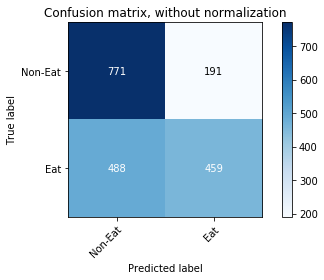

In [37]:
plot_confusion_matrix(y_test, preds_val,np.array(['Non-Eat','Eat']))

#### Testing with Unbalanced data (77670 samples)

In [38]:
#print(X_unbalanced_new.shape)
preds_val_unbalanced = clf.predict(X_unbalanced_new)
accuracy = accuracy_score(Y_unbalancedData, preds_val_unbalanced)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 78.05%


Confusion matrix, without normalization
[[58973 15276]
 [ 1721  1460]]


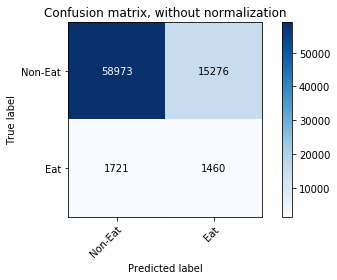

In [39]:
plot_confusion_matrix(Y_unbalancedData, preds_val_unbalanced,np.array(['Non-Eat','Eat']))

### Training Accuracy

In [40]:
print(X_train.shape)
preds_val_train = clf.predict(X_train)
accuracy = accuracy_score(y_train, preds_val_train)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

(4453, 38)
Accuracy: 61.58%


Confusion matrix, without normalization
[[1741  478]
 [1233 1001]]


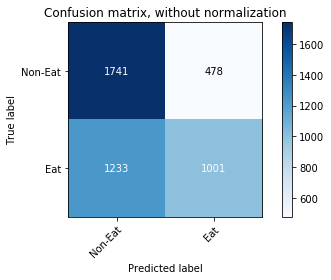

In [41]:
plot_confusion_matrix(y_train, preds_val_train,np.array(['Non-Eat','Eat']))

## Random Forest

In [42]:
from  sklearn.ensemble import RandomForestClassifier
model1 = RandomForestClassifier(random_state=0)

In [43]:
from sklearn.model_selection import GridSearchCV
parameters = {'n_estimators':(5,10,20), 
              'max_depth': range(1, 10, 5),
             }
    

In [44]:
model1.get_params().keys()

dict_keys(['bootstrap', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [45]:
gs_clf = GridSearchCV(RandomForestClassifier(random_state=0),parameters, cv=5, n_jobs=1,verbose=2)

In [46]:
print (X_train.shape, y_train.shape)
model = gs_clf.fit(X_train, y_train)

(4453, 38) (4453,)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] max_depth=1, n_estimators=5 .....................................
[CV] ...................... max_depth=1, n_estimators=5, total=   0.0s
[CV] max_depth=1, n_estimators=5 .....................................
[CV] ...................... max_depth=1, n_estimators=5, total=   0.0s
[CV] max_depth=1, n_estimators=5 .....................................
[CV] ...................... max_depth=1, n_estimators=5, total=   0.0s
[CV] max_depth=1, n_estimators=5 .....................................
[CV] ...................... max_depth=1, n_estimators=5, total=   0.0s
[CV] max_depth=1, n_estimators=5 .....................................
[CV] ...................... max_depth=1, n_estimators=5, total=   0.0s
[CV] max_depth=1, n_estimators=10 ....................................
[CV] ..................... max_depth=1, n_estimators=10, total=   0.0s
[CV] max_depth=1, n_estimators=10 ...................................

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ..................... max_depth=1, n_estimators=10, total=   0.0s
[CV] max_depth=1, n_estimators=10 ....................................
[CV] ..................... max_depth=1, n_estimators=10, total=   0.0s
[CV] max_depth=1, n_estimators=20 ....................................
[CV] ..................... max_depth=1, n_estimators=20, total=   0.0s
[CV] max_depth=1, n_estimators=20 ....................................
[CV] ..................... max_depth=1, n_estimators=20, total=   0.0s
[CV] max_depth=1, n_estimators=20 ....................................
[CV] ..................... max_depth=1, n_estimators=20, total=   0.0s
[CV] max_depth=1, n_estimators=20 ....................................
[CV] ..................... max_depth=1, n_estimators=20, total=   0.0s
[CV] max_depth=1, n_estimators=20 ....................................
[CV] ..................... max_depth=1, n_estimators=20, total=   0.1s
[CV] max_depth=6, n_estimators=5 .....................................
[CV] .

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    1.1s finished


In [47]:
print(model.best_params_)
for param_name in sorted(parameters.keys()):
    print("%s: %r" % (param_name, model.best_params_[param_name]))

{'max_depth': 6, 'n_estimators': 5}
max_depth: 6
n_estimators: 5


In [48]:
from sklearn.metrics import accuracy_score
preds_val = model.predict(X_test)
accuracy = accuracy_score(y_test, preds_val)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 64.43%


Confusion matrix, without normalization
[[771 191]
 [488 459]]


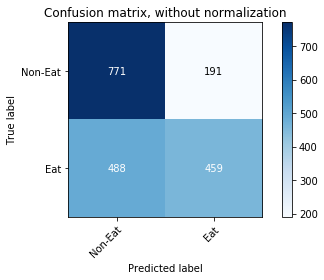

In [49]:
plot_confusion_matrix(y_test, preds_val,np.array(['Non-Eat','Eat']))

#### Training Accuracy

In [50]:
from sklearn.metrics import accuracy_score
preds_val_train = model.predict(X_train)
accuracy = accuracy_score(y_train, preds_val_train)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 61.58%


Confusion matrix, without normalization
[[1741  478]
 [1233 1001]]


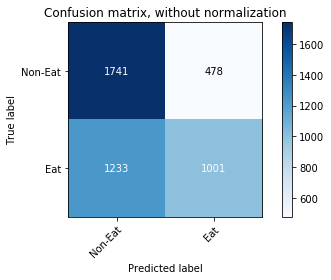

In [51]:
plot_confusion_matrix(y_train, preds_val_train,np.array(['Non-Eat','Eat']))

#### Test with unbalanced data

In [52]:
from sklearn.metrics import accuracy_score
preds_val = model.predict(X_unbalanced_new)
accuracy = accuracy_score(Y_unbalancedData, preds_val)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 78.05%


Confusion matrix, without normalization
[[58974 15275]
 [ 1721  1460]]


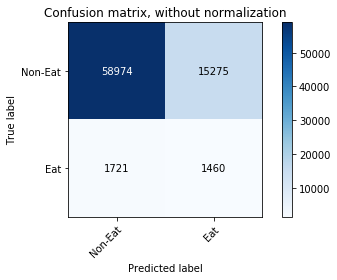

In [53]:
plot_confusion_matrix(Y_unbalancedData, preds_val,np.array(['Non-Eat','Eat']))